# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [1]:
# Imports here
"""
importing all necessary and required packages.
"""

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import torch
import torchvision
from torchvision import datasets, models, transforms
from collections import OrderedDict
import torch.nn.functional as F

from torch import nn, optim
from torch.autograd import Variable as V
import time
import numpy as np
import matplotlib.pyplot as plt
import torch.utils.data as data
from PIL import Image

In [2]:
#filter out all warnings.
import warnings
warnings.filterwarnings("ignore")

In [3]:
### https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#load-data

In [4]:
#check for the existence of cuda in the system
cuda = torch.cuda.is_available()
cuda

True

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). You can [download the data here](https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip). The dataset is split into two parts, training and validation. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. If you use a pre-trained network, you'll also need to make sure the input data is resized to 224x224 pixels as required by the networks.

The validation set is used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks available from `torchvision` were trained on the ImageNet dataset where each color channel was normalized separately. For both sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.

In [5]:
data_dir = './flower_data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'

In [6]:
# TODO: Define your transforms for the training and validation sets
"""
Tranforming data means changing the features of the data.

This enables the model to be robust in that it is trained to identify 
images no maater the nature of that dataset.

That is, the model should be able to identify a flower even if some of 
its features are cropped, or it rotated or inverted.

Tranforms help the network generalize leading to better performance.

From the instructions, tranforms seem to be specific for a dataset.
"""
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

train_transformed= transforms.Compose([
                   transforms.RandomRotation(30),
                   transforms.RandomResizedCrop(224),
                   transforms.RandomHorizontalFlip(),
                   transforms.ToTensor(),
                   transforms.Normalize(mean, std)])

valid_transformed = transforms.Compose([
                    transforms.Resize(256),
                    transforms.CenterCrop(224),
                    transforms.ToTensor(),
                    transforms.Normalize(mean, std)])

# TODO: Load the datasets with ImageFolder
train_set = datasets.ImageFolder(train_dir, transform=train_transformed)
valid_set = datasets.ImageFolder(valid_dir, transform=valid_transformed)

image_datasets = {'train':train_set, 'valid':valid_set}

#for debugging purposes, print is used to make verifications
  
print("Number of Flower Categories: ", len(train_set.classes))# verify that the number of classes equal 102.  
print("Number of smaples in the training set: ", len(train_set))
print("Number of smaples in the validation set: ", len(valid_set))
    
# TODO: Using the image datasets and the trainforms, define the dataloaders
train_loader = torch.utils.data.DataLoader(train_set, batch_size = 32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size = 32,shuffle = True)

dataloaders = {'train':train_loader, 'valid':valid_loader}


Number of Flower Categories:  102
Number of smaples in the training set:  6552
Number of smaples in the validation set:  818


### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [7]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)
    print("Flower class value :  Flower name")
    print("---------------------------------")
    for the_key, the_value in cat_to_name.items():
       
        print(the_key, '                :', the_value)

Flower class value :  Flower name
---------------------------------
21                 : fire lily
3                 : canterbury bells
45                 : bolero deep blue
1                 : pink primrose
34                 : mexican aster
27                 : prince of wales feathers
7                 : moon orchid
16                 : globe-flower
25                 : grape hyacinth
26                 : corn poppy
79                 : toad lily
39                 : siam tulip
24                 : red ginger
67                 : spring crocus
35                 : alpine sea holly
32                 : garden phlox
10                 : globe thistle
6                 : tiger lily
93                 : ball moss
33                 : love in the mist
9                 : monkshood
102                 : blackberry lily
14                 : spear thistle
19                 : balloon flower
100                 : blanket flower
13                 : king protea
49                 : oxeye dais

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


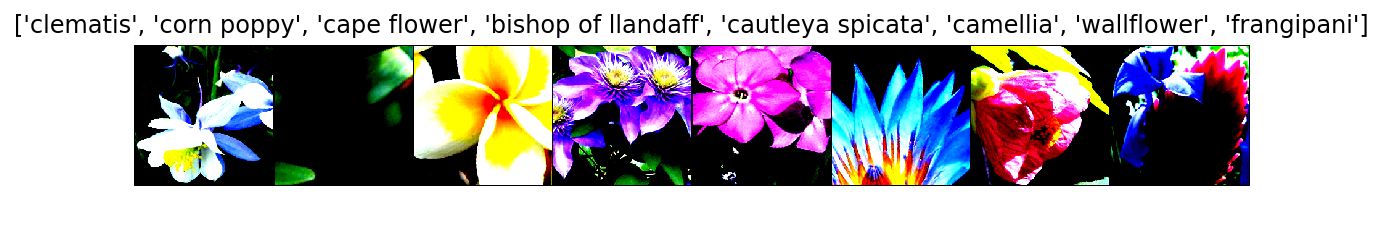

In [8]:
#visualize a few images

def visualize_imgs(inp, title=None):
    """
    This is another function used to study data.
    With this function, the appearance of a few flowers is displayed.
    One can the go ahead with a notion of how what should be displayed as outcome.
    This function is defined with reference to knowledge from
    
    https://www.kaggle.com/carloalbertobarbano/vgg16-transfer-learning-pytorch
    
    
    Arguments:
    inp:
    
    title:
    """
    inp = inp.numpy().transpose((1, 2, 0))
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


flower_set = {
    x: data.DataLoader(image_datasets[x], batch_size=8, shuffle=True)
    for x in list(image_datasets.keys())
}
# Get a batch of 8 flowers from  the data
inputs, classes = next(iter(flower_set['train']))
#make a grid from te batc
output = torchvision.utils.make_grid(inputs)
#get the names of the flowers in the batch
names = list(cat_to_name.values())

#call the visualize_imgs function  to display the flowers
visualize_imgs(output, title=[names[x] for x in classes])


# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! You can also ask questions on the forums or join the instructors in office hours.

Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

In [9]:
# TODO: Build and train your network

In [10]:

"""
Loads a pretrained model in this case VGG16, to obtain parameters to 
use in training a new model.

It takes not arguments.

It returns features as a list.

"""
# load the VGG pre-trained model.
model = models.vgg16(pretrained=True)
# freeze parameters of the model
# to prevent back propagation
for param in model.parameters():
    param.requires_grad = False
#VGG-16 architecture
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [11]:
"""
learning parameter, lr:
number of epochs:
"""

lr = 0.001 #define the learning parameter
number_epochs = 3 #define the number of epochs


In [12]:
"""
with hidden features as [4096, 1000], I experienced a cuda run time error
out of memory
Had to change hidden features to [1000, 256]
"""

input_features = 25088
hidden_features = [1000, 256]
output_features = 102
dropout_prob = 0.2
Classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(input_features, hidden_features[0])),
                          ('relu1', nn.ReLU()),
                          ('dropout1', nn.Dropout(p=dropout_prob)),
                          ('fc2', nn.Linear(hidden_features[0], hidden_features[1])),
                          ('relu2', nn.ReLU()),
                          ('dropout2', nn.Dropout(p=dropout_prob)),
                          ('fc3', nn.Linear(hidden_features[1], output_features)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
#change the classfier portion of VGG 16 
#replace it with the defined Classifier
model.classifier = Classifier


In [13]:

model.cuda()
#set the criterion to use for evaluation of model fit
criterion = nn.NLLLoss()
#the optimizer updates the weights depending on the output from a layer.
optimizer = optim.Adam(model.classifier.parameters(), lr=lr)


In [14]:
"""
Train the classifier
"""
count = 0 #initialize count 
training_loss = 0 #initialize the training loss
print_every_n = 10
# train _accu = 0
for epoch in range(number_epochs):
    model.train()    #set model to training mode
    for images, labels in iter((dataloaders['train'])):
        count += 1 #increment the count
        optimizer.zero_grad() #zero all parameters
        training_start = time.time()
        images = images.cuda()
        labels = labels.cuda()
        outputs = model.forward(images)
        loss = criterion(outputs, labels)
        loss.backward() #backword propagation and 
        optimizer.step() #optimization in the training phase
        training_loss += loss.data[0] #track the loss during training
        
       
        if count % print_every_n == 0:
            model.eval()    #set model to evaluation mode
            #during validation, backward propagation and optimization are not allowed
            val_accu = 0 #initialize the validation accuracy
            val_loss = 0 #initialize the validation loss
            for ii, (images, labels) in enumerate(dataloaders['valid']):
                images = images.cuda()
                labels = labels.cuda()
                output = model.forward(images)
                val_loss += criterion(output, labels).data[0]
                ps = torch.exp(output).data
                equality = (labels.data == ps.max(1)[1])
                val_accu += equality.type_as(torch.FloatTensor()).mean()
            print("Epoch: {}/{}.. ".format(epoch+1, number_epochs))
            print("Train Loss: {:.2f}.. ".format(training_loss/print_every_n))
            print("Valid Loss: {:.2f}.. ".format(val_loss/len(dataloaders['valid'])))
            #take an average of the validation accuracy
            print("Valid Accu: {:.2f}".format(val_accu/len(dataloaders['valid'])))
            print()
            #reset the training loss
            training_loss = 0
            
            # after each epoch, switch the mode to training mode.
            model.train()

Epoch: 1/3.. 
Train Loss: 4.75.. 
Valid Loss: 4.36.. 
Valid Accu: 0.14

Epoch: 1/3.. 
Train Loss: 4.44.. 
Valid Loss: 4.06.. 
Valid Accu: 0.14

Epoch: 1/3.. 
Train Loss: 4.14.. 
Valid Loss: 3.69.. 
Valid Accu: 0.19

Epoch: 1/3.. 
Train Loss: 3.88.. 
Valid Loss: 3.35.. 
Valid Accu: 0.27

Epoch: 1/3.. 
Train Loss: 3.57.. 
Valid Loss: 3.07.. 
Valid Accu: 0.29

Epoch: 1/3.. 
Train Loss: 3.52.. 
Valid Loss: 2.85.. 
Valid Accu: 0.33

Epoch: 1/3.. 
Train Loss: 3.27.. 
Valid Loss: 2.51.. 
Valid Accu: 0.39

Epoch: 1/3.. 
Train Loss: 2.99.. 
Valid Loss: 2.30.. 
Valid Accu: 0.45

Epoch: 1/3.. 
Train Loss: 2.90.. 
Valid Loss: 2.15.. 
Valid Accu: 0.47

Epoch: 1/3.. 
Train Loss: 2.80.. 
Valid Loss: 2.05.. 
Valid Accu: 0.49

Epoch: 1/3.. 
Train Loss: 2.53.. 
Valid Loss: 1.89.. 
Valid Accu: 0.52

Epoch: 1/3.. 
Train Loss: 2.48.. 
Valid Loss: 1.73.. 
Valid Accu: 0.56

Epoch: 1/3.. 
Train Loss: 2.46.. 
Valid Loss: 1.64.. 
Valid Accu: 0.56

Epoch: 1/3.. 
Train Loss: 2.22.. 
Valid Loss: 1.52.. 
Valid Accu

## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [15]:
# TODO: Save the checkpoint 
# https://pytorch.org/tutorials/beginner/saving_loading_models.html
model.class_to_idx = dataloaders['train'].dataset.class_to_idx
model.epochs = number_epochs
model.cuda()
checkpoint = {'Pretrained_arch': 'VGG16',
              'input_size': 25088,
              'output_size': 102,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict':optimizer.state_dict(),
              'class_to_idx': model.class_to_idx,
              'batch_size': 32,
              'epoch': model.epochs
             }
torch.save(checkpoint, 'checkpoint.pth')

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [16]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    #load pretrained model
    model = models.vgg16(pretrained=True)
    #freeze parameters
    for param in model.parameters():
        param.requires_grad = False
    #define variables
    input_features = 25088
    hidden_features = [1000, 256]
    output_features = 102
    drop_prob = 0.2
    
    model.class_to_idx = checkpoint['class_to_idx']
    #define the classifier
    clf = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(input_features, hidden_features[0])),
                          ('relu1', nn.ReLU()),
                          ('dropout1', nn.Dropout(p=drop_prob)),
                          ('fc2', nn.Linear(hidden_features[0], hidden_features[1])),
                          ('relu2', nn.ReLU()),
                          ('dropout2', nn.Dropout(p=drop_prob)),
                          ('fc3', nn.Linear(hidden_features[1], output_features)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    #replace the classifier in the model
    model.classifier = clf
    
    model.load_state_dict(checkpoint['model_state_dict'])
    return model

model = load_checkpoint('checkpoint.pth')
    

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [17]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # TODO: Process a PIL image for use in a PyTorch model
    pil_image= Image.open(image)
    
    #resize the image
    size=256,256
    pil_image.thumbnail(size)
    
    #crop the image
    width, height = 256, 256
    bottom = (height + 224)/2
    top = (height - 224)/2
    right = (width + 224)/2
    left = (width - 224)/2
    image = np.array(pil_image.crop((left, top, right, bottom)))   
    
    #normalize the image
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    image=(image/255-mean)/std
    image= np.transpose(image, (2, 0, 1))
    
    return image

#takae an image process it and check it dimensions
img = process_image(valid_dir +'/3/image_06621.jpg')
print("Resulting Image Dimensions", img.shape)


Resulting Image Dimensions (3, 224, 224)


To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [18]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [19]:
def predict(img, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file
    
    model.cpu()
    #process the image
    image = process_image(img)
    
    #convert image -> tensor that can be used by the model
    tensor_image = torch.from_numpy(image).double()
    inputs = V(tensor_image)
    #add batch size of one to the image
    inputs = inputs.unsqueeze(0)
    
    inputs = inputs.float()
    #calcualate probabilities of the image being in the 
    #top five classes 
    output = model.forward(inputs)  
    ps=torch.exp(output)
    high_probs=torch.topk(ps,topk,dim=1)
    probabilities = high_probs[0][0]  
    top_classes = high_probs[1][0]
    probs = probabilities.detach().numpy().tolist()
    classes=top_classes.detach().numpy().tolist()
    
    return probs, classes

In [20]:
import pandas as pd
probs, flower_cats = predict('flower_data/train/43/image_02317.jpg', model)

prob_table = pd.DataFrame(
    {"Possible Flower Categories": flower_cats,
     'Probability of correspondence to each class': probs
    })
prob_table

Possible Flower Categories  Probability of correspondence to each class
0                          40                                     0.652358
1                          12                                     0.226845
2                          98                                     0.040208
3                          86                                     0.015717
4                          96                                     0.013088

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the validation accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [21]:
# TODO: Display an image along with the top 5 classes
def plot_solution(img_path):
    
    """
    This function takes an image from the path provided
    The image is passed through the predict funtio which predicts
    the top 5 classes to which the image could possibly belong
    with 5 different probabilities of correspondense to the different
    classes.
    
    This function plts a bar chart for the results generated.
    """
    plt.figure(figsize = (10,10))
   
    image = Image.open(img_path)
    fig, ax = plt.subplots(2,1)
    ax[0].imshow(image)
    #preict the classes with the probabilities.
    probs, classes = predict(img_path, model, 5)
    #get the titles of the classes.
    class_titles = train_set.classes 
    flower = [cat_to_name[class_titles[name]] for name in classes]
    
    ax[0].set_title(flower[0])  
    yaxis= np.arange(len(classes))
    ax[1].invert_yaxis()
    ax[1].barh(yaxis, probs, align='center', color='black')
    ax[1].set_yticks(yaxis)
    ax[1].set_yticklabels(flower)
    

<Figure size 720x720 with 0 Axes>

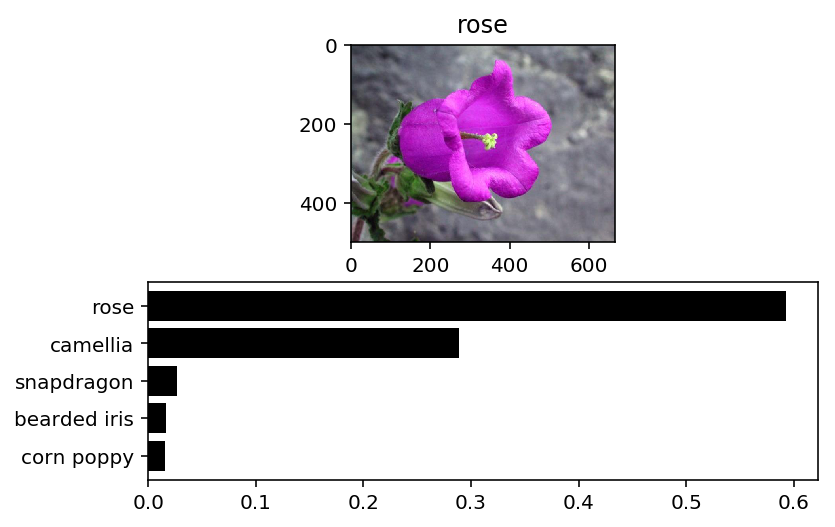

In [22]:
image_path = 'flower_data/valid/3/image_06621.jpg'

probs, flower_cats = predict(image_path, model)

plot_solution(image_path)

In [23]:
image_path = 'flower_data/valid/18/image_04278.jpg'

<Figure size 720x720 with 0 Axes>

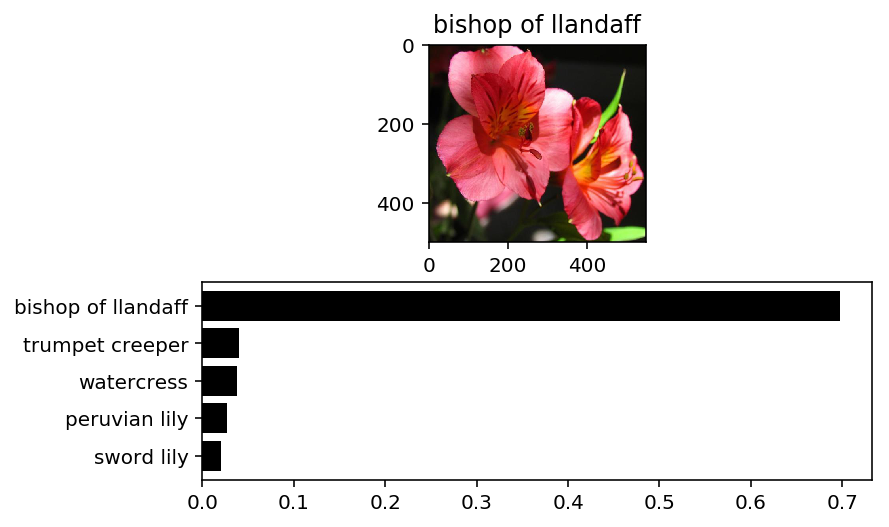

In [24]:
probs, flower_cats = predict(image_path, model)

plot_solution(image_path)